<a href="https://colab.research.google.com/github/Likhithrajanvesh/COVID-19-Detection-From-X-Ray/blob/master/Covid_19_with_xai_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/Likhithrajanvesh/COVID-19-Detection-From-X-Ray.git
!ls /content/COVID-19-Detection-From-X-Ray/data/X-Ray_Image_DataSet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications import VGG19
from keras.layers import AveragePooling2D,MaxPool2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

fatal: destination path 'COVID-19-Detection-From-X-Ray' already exists and is not an empty directory.
Covid-19  No_findings


In [5]:
# The path of our data on drive
data_dir =  r"/content/COVID-19-Detection-From-X-Ray/data/X-Ray_Image_DataSet"

# Loading Data
data = load_files(data_dir)

In [6]:
folders=os.listdir("/content/COVID-19-Detection-From-X-Ray/data/X-Ray_Image_DataSet")
print(folders)

['No_findings', 'Covid-19']


In [7]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /content/COVID-19-Detection-From-X-Ray/data/X-Ray_Image_DataSet/No_findings/00002550_000.png
Target labels -  1
Number of training files :  625
Number of training targets :  625


In [8]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)

        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape)
print('First training item : ',X[0])

(625, 224, 224, 3)
First training item :  [[[35. 35. 35.]
  [32. 32. 32.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 [[30. 30. 30.]
  [26. 26. 26.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [23. 23. 23.]]

 [[22. 22. 22.]
  [22. 22. 22.]
  [24. 24. 24.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 ...

 [[24. 24. 24.]
  [27. 27. 27.]
  [55. 55. 55.]
  ...
  [67. 67. 67.]
  [78. 78. 78.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [25. 25. 25.]
  [41. 41. 41.]
  ...
  [76. 76. 76.]
  [82. 82. 82.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [30. 30. 30.]
  [25. 25. 25.]
  ...
  [77. 77. 77.]
  [81. 81. 81.]
  [73. 73. 73.]]]


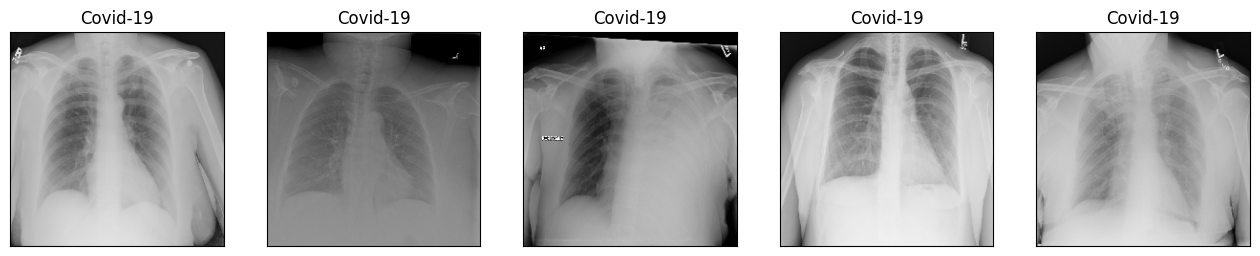

In [9]:
#Let's look at first 5 training data.
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [10]:
"""
   After that data is converted into Numpy array, Now,
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :)
no_of_classes = len(np.unique(y))
no_of_classes

2

In [11]:
y

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,

In [12]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Assuming you have a class vector 'y' and the number of classes 'no_of_classes'

# One-hot encode the labels using to_categorical:
y = tf.keras.utils.to_categorical(y, no_of_classes)

# Access the first element of the encoded matrix:
first_encoded_label = y[0]

# You can now use the one-hot encoded labels for your model.
first_encoded_label

array([0., 1.], dtype=float32)

In [13]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  500
The validation Data Shape  63
The test Data Shape  62


In [14]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


In [15]:
VGG19_model = keras.applications.VGG19(input_shape= X_train.shape[1:], include_top=False, weights="imagenet")
# setting the VGG model to be untrainable.
VGG19_model.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [16]:
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from keras.layers import BatchNormalization
Model = Sequential()
Model.add(VGG19_model)
Model.add(BatchNormalization())
Model.add(Dropout(0.20))
Model.add(Flatten())
Model.add(Dense(256,activation='relu'))
Model.add(Dense(2,activation='softmax'))
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [18]:
lr = 1e-4
bs = 8
optimizer = Adam(lr=1e-4)
Model.compile(optimizer, loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [19]:
# Time to train our model !
epochs = 20

#initialize the training data augmentation object
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

checkpointer = ModelCheckpoint(filepath = "/content/NouredAminaVGG19m.h5", save_best_only = True, verbose=1)
start = time.time()

# let's get started !

history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)/bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)/bs,
                            epochs =epochs,
                            callbacks= [checkpointer])

end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/20


<ipython-input-19-b4e3ac22d950>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


63/62 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.9220
Epoch 1: val_loss improved from inf to 0.06759, saving model to /content/NouredAminaVGG19m.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 21s 209ms/step - loss: 0.4767 - accuracy: 0.9220 - val_loss: 0.0676 - val_accuracy: 1.0000
Epoch 2/20
63/62 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.9240
Epoch 2: val_loss improved from 0.06759 to 0.04636, saving model to /content/NouredAminaVGG19m.h5
62/62 [==============================] - 8s 124ms/step - loss: 0.3284 - accuracy: 0.9240 - val_loss: 0.0464 - val_accuracy: 1.0000
Epoch 3/20
63/62 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9480
Epoch 3: val_loss improved from 0.04636 to 0.03083, saving model to /content/NouredAminaVGG19m.h5
62/62 [==============================] - 7s 115ms/step - loss: 0.1528 - accuracy: 0.9480 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 4/20
63/62 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9720
Epoch 4: val_loss did not improve from 0.03083
62/62 [==============================] - 8s 122ms/step - loss: 0.0925 - accuracy:

In [20]:
(eval_loss, eval_accuracy) = Model.evaluate(
     X_test, y_test, batch_size=bs, verbose=2)

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

8/8 - 3s - loss: 0.1789 - accuracy: 0.9677 - 3s/epoch - 322ms/step
Accuracy: 96.77%
Loss: 0.17886677384376526


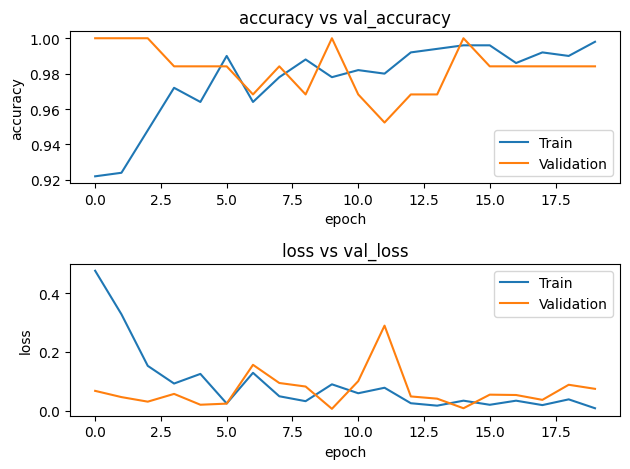

In [21]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt
def plot(history):
    plt.figure(1)
     # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy vs val_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

     # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss vs val_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

# Finaly, let's call the plot function with the 'result' parameter

plot(history)

2/2 [==============================] - 13s 6s/step


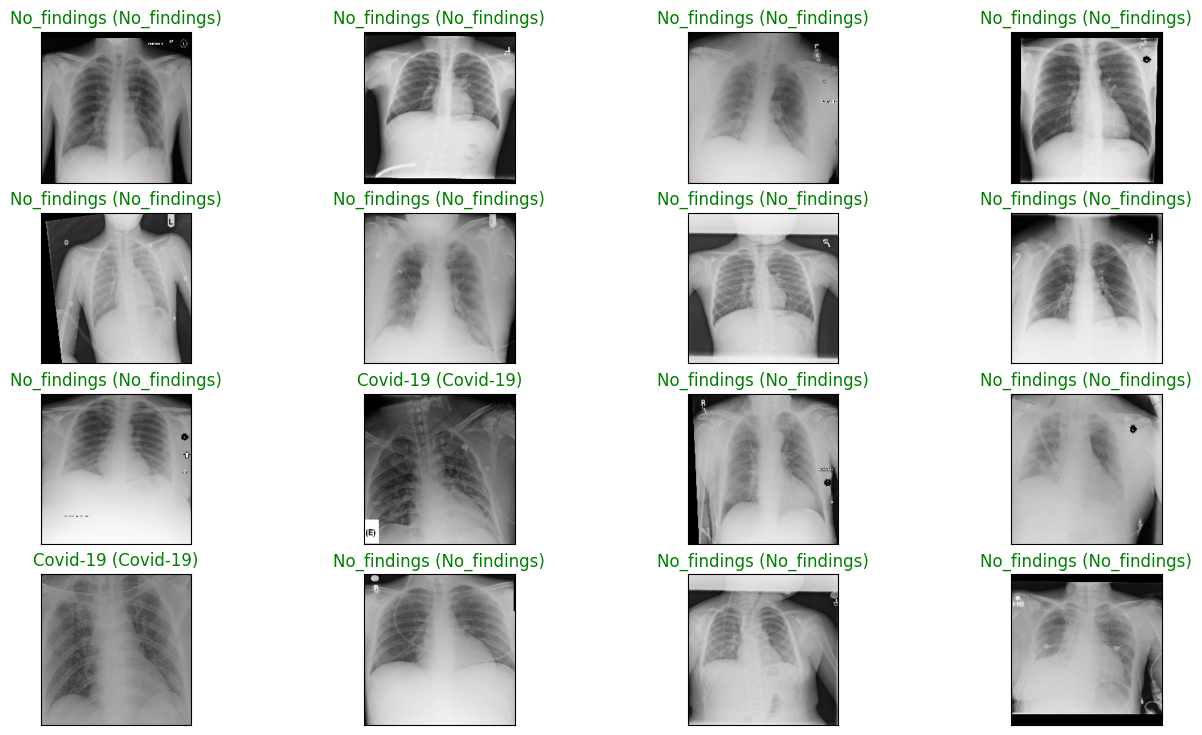

In [22]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(Model.predict(X_test))

2/2 [==============================] - 0s 188ms/step


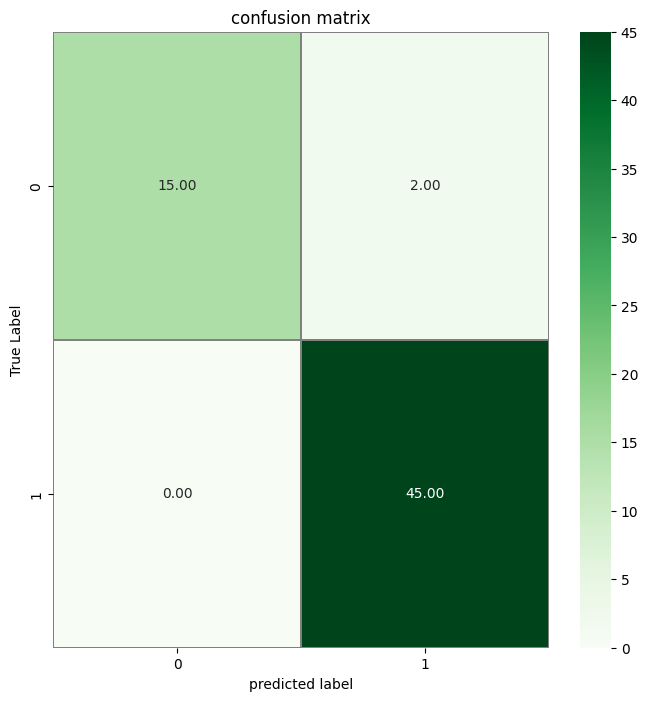

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [24]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       1.00      0.88      0.94        17
 No_findings       0.96      1.00      0.98        45

    accuracy                           0.97        62
   macro avg       0.98      0.94      0.96        62
weighted avg       0.97      0.97      0.97        62



In [25]:
my_model=keras.models.load_model("/content/NouredAminaVGG19m.h5")

2/2 [==============================] - 0s 148ms/step


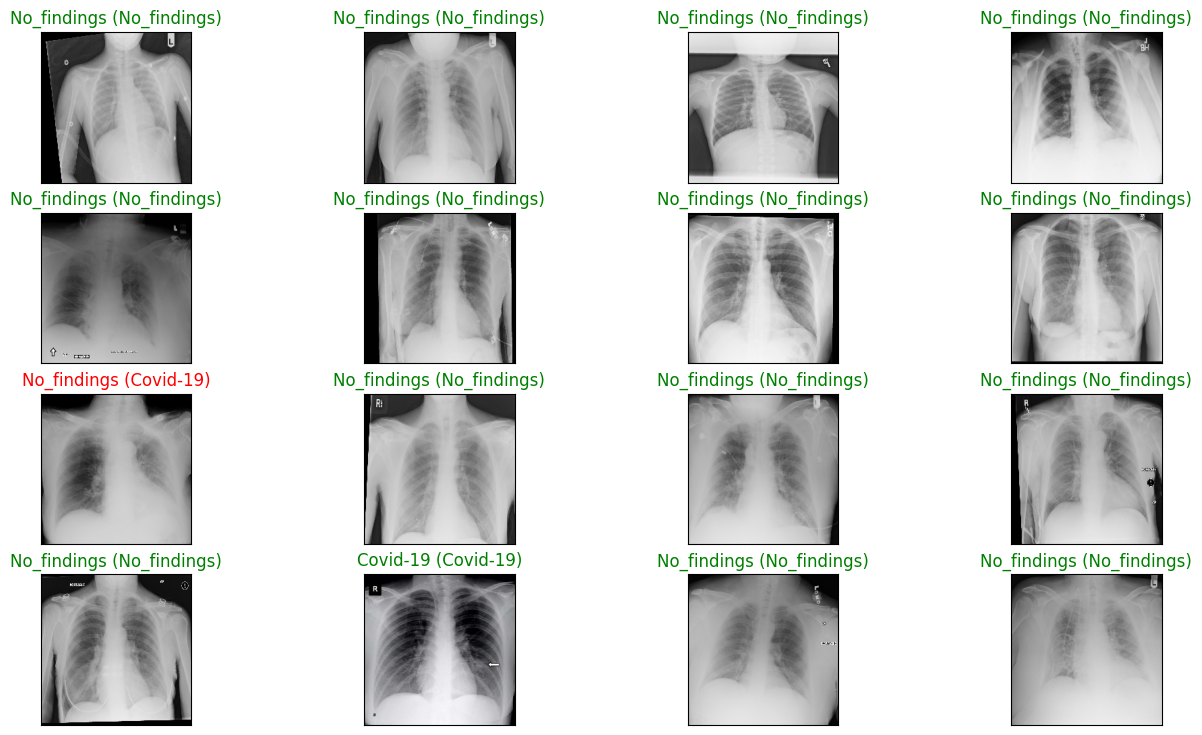

In [26]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=ffcb2938686fcaf94892c268ca7a61a8442a3bbaa8f488750f91c438b4fa9d96
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
35363/35363 [==============================] - 0s 0us/step
Top Predictions:
('n01943899', 'conch', 0.2848986)
('n04040759', 'radiator', 0.25244686)
('n02895154', 'breastplate', 0.059836626)


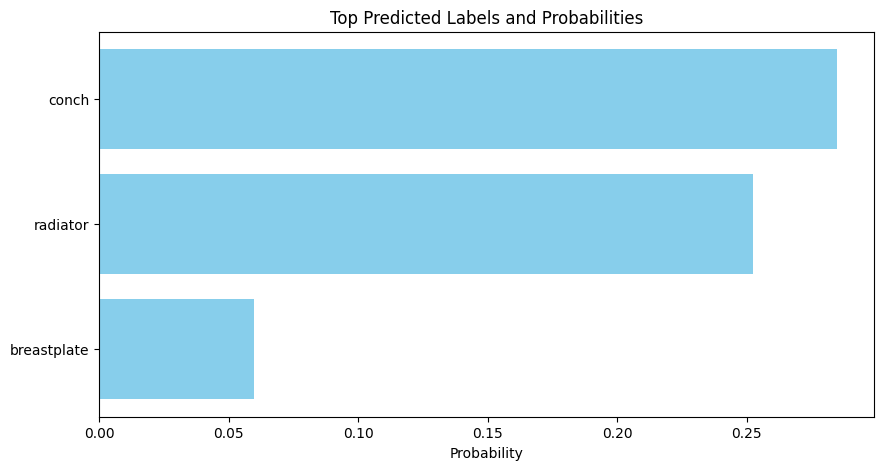


Explanation for 'conch' (Score: 0.28):


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


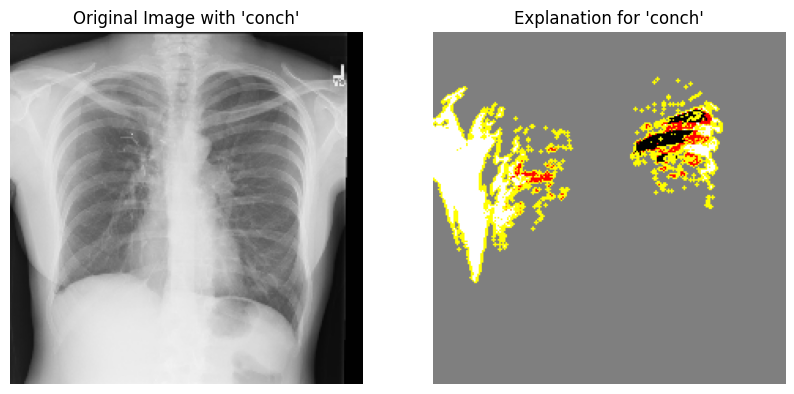


Explanation for 'radiator' (Score: 0.25):


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


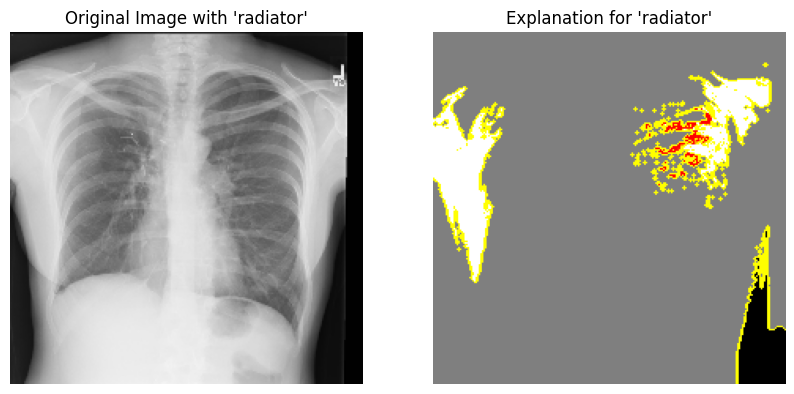


Explanation for 'breastplate' (Score: 0.06):


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


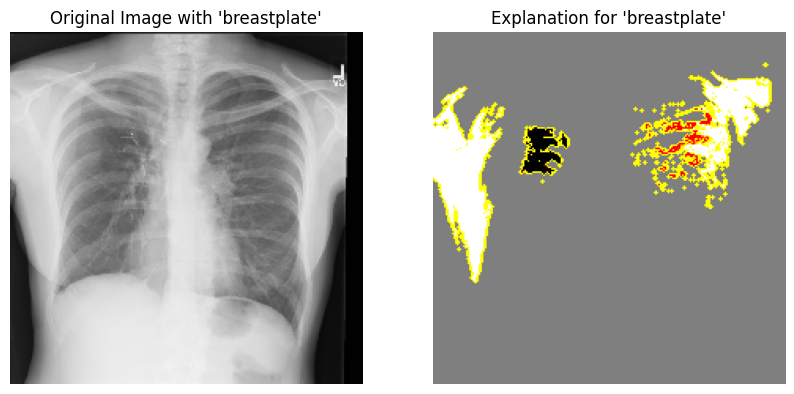

In [27]:
!pip install lime
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load pre-trained VGG19 model
model = VGG19(weights='imagenet')

# Load and preprocess the image
img_path = '/content/COVID-19-Detection-From-X-Ray/data/X-Ray_Image_DataSet/No_findings/00001280_004.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict with the model
preds = model.predict(img_array)
top_preds = decode_predictions(preds, top=3)[0]

print('Top Predictions:')
for pred in top_preds:
    print(pred)

# Plot bar chart for prediction probabilities
labels = [label for (_, label, _) in top_preds]
probabilities = [prob for (_, _, prob) in top_preds]

plt.figure(figsize=(10, 5))
plt.barh(labels, probabilities, color='skyblue')
plt.xlabel('Probability')
plt.title('Top Predicted Labels and Probabilities')
plt.gca().invert_yaxis()  # Invert y-axis to have highest probability on top
plt.show()

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanations for top predicted labels
for idx, (label_id, label, score) in enumerate(top_preds):
    print(f"\nExplanation for '{label}' (Score: {score:.2f}):")
    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    # Display image with LIME explanation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image with '{label}'")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Explanation for '{label}'")
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.axis('off')

    plt.show()
